In [1]:
from __future__ import print_function

import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})
import torchvision.datasets as dset
import torchvision.transforms as tforms

import torch.utils.data as data
from torch.utils.data import Dataset
from IPython.core.debugger import Tracer

from PIL import Image
import os
import os.path
import errno
import numpy as np
import torch
import codecs

In [2]:
class ColorMNIST(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))
            
            self.train_data = np.tile(self.train_data[:, :, :, np.newaxis], 3)
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))
            
            self.test_data = np.tile(self.test_data[:, :, :, np.newaxis], 3)
        
        self.pallette = [[31, 119, 180],
                         [255, 127, 14],
                         [44, 160, 44],
                         [214, 39, 40],
                         [148, 103, 189],
                         [140, 86, 75],
                         [227, 119, 194],
                         [127, 127, 127],
                         [188, 189, 34],
                         [23, 190, 207]]

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]
        
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        y_color_digit = np.random.randint(0, 10)
        c_digit = self.pallette[y_color_digit]
        
        img[:, :, 0] = img[:, :, 0] / 255 * c_digit[0]
        img[:, :, 1] = img[:, :, 1] / 255 * c_digit[1]
        img[:, :, 2] = img[:, :, 2] / 255 * c_digit[2]
        
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, [target,torch.from_numpy(np.array(y_color_digit))]

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import gzip

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

[tensor([8, 6, 2, 0, 4, 8, 1, 5, 7, 7]), tensor([0, 0, 1, 6, 8, 6, 0, 5, 3, 3])]


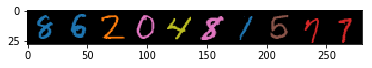

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


> <ipython-input-5-6e862cd9941e>(35)<module>()
     33     train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=10, shuffle=True, drop_last=True, pin_memory=True)
     34     xall = []
---> 35     for _, (x, y) in enumerate(train_loader):
     36         print(y)
     37         ximg = x.numpy().transpose((0,2,3,1))



ipdb>  quit


Exiting Debugger.


In [5]:
def add_noise(x):
    """
    [0, 1] -> [0, 255] -> add noise -> [0, 1]
    """
    noise = x.new().resize_as_(x).uniform_()
    x = x * 255 + noise
    x = x / 256
    return x

def get_train_loader(train_set, epoch):
    if args.batch_size_schedule != "":
        epochs = [0] + list(map(int, args.batch_size_schedule.split("-")))
        n_passed = sum(np.array(epochs) <= epoch)
        current_batch_size = int(args.batch_size * n_passed)
    else:
        current_batch_size = args.batch_size
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=current_batch_size, shuffle=True, drop_last=True, pin_memory=True
    )
    logger.info("===> Using batch size {}. Total {} iterations/epoch.".format(current_batch_size, len(train_loader)))
    return train_loader

trans = lambda im_size: tforms.Compose([tforms.Resize(im_size), tforms.ToTensor(), add_noise])
im_dim = 1
im_size = 28

train_set = ColorMNIST(root="../data", train=True, transform=trans(im_size), download=True)
test_set = ColorMNIST(root="../data", train=False, transform=trans(im_size), download=True)
data_shape = (im_dim, im_size, im_size)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=500, shuffle=False, drop_last=True)

for epoch in range(1, 11):
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=10, shuffle=True, drop_last=True, pin_memory=True)
    xall = []
    for _, (x, y) in enumerate(train_loader):
        print(y)
        ximg = x.numpy().transpose((0,2,3,1))
        for i in range(ximg.shape[0]):
            xall.append(ximg[i])
        
        xall = np.hstack(xall)

        plt.imshow(xall)
        plt.show()
        Tracer()()
    

In [ ]:
from colormnist import ColorMNIST

dataloader = ColorMNIST('back', 'train', path_to_mnist, randomcolor=False)

x_all = []
for i in [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]:
    x_all.append(dataloader[i][0].numpy().transpose([1, 2, 0]))
x_all = np.hstack(x_all)

Tracer()()
plt.imshow(x_all)
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  # Remove the CWD from sys.path while we load stuff.


--Return--
None
> <ipython-input-8-b537f0cf81f1>(10)<module>()
      8 x_all = np.hstack(x_all)
      9 
---> 10 Tracer()()
     11 plt.imshow(x_all)
     12 plt.show()



ipdb>  x_all


array([[[0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0.46666667, 0.7058824 ],
        ...,
        [0.09019608, 0.74509805, 0.8117647 ],
        [0.09019608, 0.74509805, 0.8117647 ],
        [0.09019608, 0.74509805, 0.8117647 ]],

       [[0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0.46666667, 0.7058824 ],
        ...,
        [0.09019608, 0.74509805, 0.8117647 ],
        [0.09019608, 0.74509805, 0.8117647 ],
        [0.09019608, 0.74509805, 0.8117647 ]],

       [[0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0.46666667, 0.7058824 ],
        ...,
        [0.09019608, 0.74509805, 0.8117647 ],
        [0.09019608, 0.74509805, 0.8117647 ],
        [0.09019608, 0.74509805, 0.8117647 ]],

       ...,

       [[0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0.46666667, 0.7058824 ],
        [0.12156863, 0

ipdb>  x_all.shape


(28, 280, 3)
--KeyboardInterrupt--


ipdb>  quit
ipdb>  quit


In [ ]:
dataloader = ColorMNIST('num', 'train', path_to_mnist, randomcolor=False)

x_all = []
for i in [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]:
    x_all.append(dataloader[i][0].numpy().transpose([1, 2, 0]))
x_all = np.hstack(x_all)

plt.imshow(x_all)
plt.show()

In [ ]:
dataloader = ColorMNIST('both', 'train', path_to_mnist, randomcolor=False)

x_all = []
for i in [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]:
    x_all.append(dataloader[i][0].numpy().transpose([1, 2, 0]))
x_all = np.hstack(x_all)

plt.imshow(x_all)
plt.show()

In [ ]:
dataloader = ColorMNIST('both', 'train', path_to_mnist, randomcolor=True)

x_all = []
for i in [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]:
    x_all.append(dataloader[i][0].numpy().transpose([1, 2, 0]))
x_all = np.hstack(x_all)

plt.imshow(x_all)
plt.show()

In [7]:
num_rgb_channels = 3
num_exclude = np.random.randint(num_rgb_channels, size=3)
exclude_channels = [np.sort(np.random.choice(num_rgb_channels, ne, replace=False)) for ne in num_exclude] 
print(num_exclude)
print(exclude_channels)

[1 2 2]
[array([2]), array([1, 2]), array([0, 2])]


In [8]:
print(np.random.randint(0, 10))

8
